# Text Processing on Haptik Dataset
#### Firstly we will import all the packages required for all the processing required like data cleaning, 
#### data prerocessing, building model

In [91]:
#future imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

#Data Cleaning packages
from pandas import read_csv, Series, DataFrame
from numpy import array, ravel
from nltk.tokenize import TreebankWordTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import operator
import copy
from collections import OrderedDict
from string import punctuation

#Visulaization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Time
import time   

#Model Fitting
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier

In [42]:
#timeit Decorator
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [43]:
@timeit
def load_dataset(filepath):
    dataset = read_csv(filepath, encoding = 'UTF-8')
    
    return dataset

train = load_dataset('./train_data.csv')

test = load_dataset('./test_data.csv') 

'load_dataset'  83.66 ms
'load_dataset'  18.87 ms


In [44]:
#separating feature and target variable
@timeit
def feature_target(df):
    feature = df.iloc[:,0]
    target = df.iloc[:,1:]
    return feature, target

X_train, y_train = feature_target(train)
X_test, y_test = feature_target(test)
# X is the Feature while y is the Label

'feature_target'  0.53 ms
'feature_target'  0.54 ms


In [45]:
X_test.head()

0                                Nearest metro station
1                    Pick up n drop service trough cab
2                                I wants to buy a bick
3                                        Show me pizza
4    What is the cheapest package to andaman and ni...
Name: message, dtype: object

In [46]:
@timeit
def multi_label_binarizer(df):
    """Maps ["T", "F"] to [1, 0] in a given dataframe
    """
    #dfmi.astype(str).applymap(lambda x: '%i' % pd.Series(x).map({'a':0, 'b':1}))
    df = df.astype(str).applymap(lambda x: 1 if x=='T' else 0)
    return df

target = multi_label_binarizer(y_train)
test_target = multi_label_binarizer(y_test)
target.head()

'multi_label_binarizer'  269.88 ms
'multi_label_binarizer'  68.63 ms


,food,recharge,support,reminders,travel,nearby,movies,casual,other
0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0


In [47]:
@timeit
def normalized():
    freq = ravel(target.sum(axis = 0))
    freq = dict(zip(target.columns, freq))
    freq = OrderedDict(sorted(freq.items(), key = operator.itemgetter(1)))
    yhist = DataFrame({'label':freq.keys(), 'count':freq.values()})
    yhist['normalized'] = yhist['count']/yhist['count'].sum()
    return yhist

yhist = normalized()

'normalized'  5.35 ms


#### now we will work on train_feature dataframe


In [48]:
#stop word removal 
sw_curated = ['a9c0', 'f0af5ee2b89b', '676951', 'hi', '727893', '55616', 'task_nam',
             'user_id', '50', '16', 'exotel','ok', 'haptik', 'nearbi',
             'api_nam', 'offset', 'user_id', '00', 'pleas', 'can', 'pl',
             'drink_water', 'reminer_list', 'trains_api', 'product_id',
             'I', 'j', 'se', 'sl', '10', 'hai', 'll', 'kya', 'rs', 'sorri',
             'know', '30', 'one', '10 00', 'bu', 'reminder_list',
             'plz', 'everi']


@timeit   
def preprocess(X):
    #create english stop word list
    en_stop = get_stop_words('en')
    stemmer = PorterStemmer()
    tokenize = TreebankWordTokenizer()
    
    X = X.apply(lambda row: row.lower())
    X = X.apply(lambda row: tokenize.tokenize(row)) # do tokenization
    X = X.apply(lambda row: [i for i in row if i not in en_stop]) # remove english stop words
    X = X.apply(lambda row :[i for i in row if i not in punctuation]) #remove punctuation
    X = X.apply(lambda row:[stemmer.stem(word) for word in row])      #porter Stemmer 
    X = X.apply(lambda row: [i for i in row if i not in sw_curated])  #remove sw_curated string from X
    return X

X_train = preprocess(X_train)
X_test = preprocess(X_test)
X_train.head()

'preprocess'  12630.00 ms
'preprocess'  2888.64 ms


0                                [7am, everyday]
1                                 [chocol, cake]
2    [close, mortic, tenon, joint, door, diment]
3                        [train, eppo, kelambum]
4            [yesterday, cancel, flight, ticket]
Name: message, dtype: object

In [49]:
# Count Vectorizer
@timeit
def count_vector(X_train, X_test):
    vect = CountVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.5)
    X_train = Series([' '.join(x) for x in X_train])
    X_test = Series([' '.join(x) for x in X_test])
    train_dtm = vect.fit_transform(X_train)
    test_dtm = vect.transform(X_test)
    return vect, train_dtm, test_dtm

vect, train_dtm, test_dtm = count_vector(X_train, X_test)
vect.vocabulary_.values()

'count_vector'  1382.36 ms


[3645,
 3440,
 6901,
 11418,
 15253,
 14054,
 13696,
 18199,
 17906,
 2747,
 4842,
 1000,
 6974,
 3581,
 1407,
 6011,
 11666,
 13447,
 4176,
 15242,
 14967,
 17584,
 5630,
 5635,
 3247,
 7966,
 14277,
 17888,
 13079,
 15734,
 11532,
 17504,
 17508,
 17510,
 12256,
 16756,
 2143,
 16590,
 16127,
 3345,
 18232,
 765,
 14806,
 5526,
 7848,
 6317,
 1801,
 10820,
 6407,
 6432,
 6441,
 17017,
 14669,
 14668,
 13656,
 1764,
 3868,
 12466,
 1043,
 9949,
 9948,
 9947,
 9953,
 9952,
 9951,
 9950,
 9955,
 9954,
 14558,
 15198,
 9277,
 14410,
 10561,
 16598,
 8126,
 9642,
 16595,
 15656,
 10685,
 10134,
 10133,
 16159,
 11294,
 10033,
 14421,
 2550,
 14443,
 1259,
 14547,
 3099,
 3265,
 17576,
 17296,
 691,
 8980,
 15655,
 5741,
 4005,
 4090,
 224,
 13820,
 2251,
 13887,
 278,
 2108,
 4027,
 11582,
 2434,
 17723,
 879,
 8414,
 9656,
 5020,
 9349,
 6148,
 6149,
 10216,
 2529,
 11791,
 497,
 17573,
 4206,
 561,
 6673,
 6728,
 6722,
 10636,
 12127,
 16238,
 13874,
 8338,
 7086,
 6792,
 7929,
 7921,
 

In [50]:
def tok_freq_count(X):
    freq = ravel(X.sum(axis=0))
    vocab = [v[0] for v in sorted(vect.vocabulary_.items(), key=operator.itemgetter(1))]
    freq_sorted = dict(zip(vocab, freq))
    freq_dict = OrderedDict(freq_sorted.items(), key=operator.itemgetter(1))
    wordfreq = DataFrame({'word': freq_dict.keys(), 'count': freq_dict.values()})
    return wordfreq

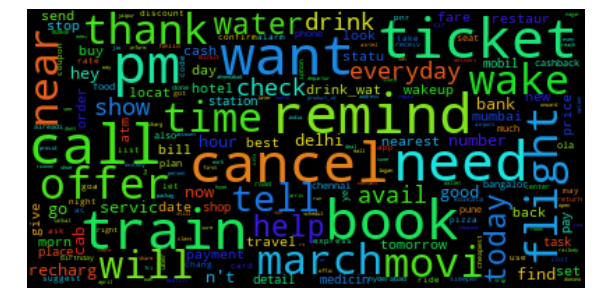

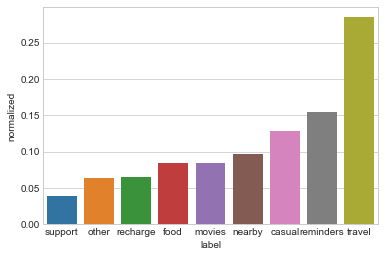

In [51]:
# wordCloud for visualization

def wordCloud(X_train):
    text = []
    for i in range(len(X_train)):
        text = text + [i for i in X_train[i]]
    textall = " ".join(text)
    wordcloud = WordCloud(max_font_size=40).generate(textall)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    return plt.show()

wordCloud(X_train)
    
def yhist_plot(yhist):
    sns.set_style("whitegrid")
    ax = sns.barplot(x="label", y="normalized", data=yhist)
    return plt.show()

yhist_plot(yhist)

In [37]:
print(train_dtm.shape)
print(test_dtm.shape)
print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)

(40659, 18450)
(10000, 18450)
(40659, 9)
(10000, 9)
(40659,)
(10000,)


In [58]:
target.head()

,food,recharge,support,reminders,travel,nearby,movies,casual,other
0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0


In [104]:
@timeit
def subset_accuracy():
    X_train = copy.deepcopy(train_dtm)
    X_test = copy.deepcopy(test_dtm)
    y_train = copy.deepcopy(target)
    y_test = copy.deepcopy(test_target)

    model = OneVsRestClassifier(MultinomialNB())
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
#     print ("Subset Accuracy: {0}".format(accuracy_score(y_test, prediction)))
    return prediction

prediction = subset_accuracy()

'subset_accuracy'  211.43 ms


In [105]:
@timeit
def label_accuracy():
    y_test = copy.deepcopy(test_target)
    y_pred = prediction
    
    res = (y_test == y_pred)
    return res.sum().sum()/res.size

result = label_accuracy()

'label_accuracy'  8.80 ms


In [106]:
@timeit
def scores():
    print ("Subset Accuracy: {0}".format(accuracy_score(y_test, prediction)))
    print ("Label Accuracy: %.4f" %(result))
    print ("Classification Report: \n{0}".format(classification_report(y_test, prediction)))
    
scores()

Subset Accuracy: 0.6259
Label Accuracy: 0.9390
Classification Report: 
             precision    recall  f1-score   support

          0       0.82      0.61      0.70       810
          1       0.71      0.66      0.68       450
          2       0.71      0.39      0.50       371
          3       0.88      0.81      0.84       893
          4       0.80      0.86      0.83      2138
          5       0.57      0.64      0.60       807
          6       0.81      0.57      0.67       637
          7       0.90      0.55      0.68      3282
          8       0.91      0.63      0.74      1668

avg / total       0.83      0.65      0.72     11056

'scores'  36.36 ms
